前面一部分主要讲了神经网络在前向传播过程中对数据的处理,包括**去均值预处理**, **权重初始化**, 在线性输出结果和激活函数之间**批量归一化BN**,以及进入下一层layer之前的**随机失活**.

那么这一部分将介绍在反向传播过程中对梯度下降的处理,也就是几种优化算法.

真的很佩服这些人...一个梯度下降,你之前可能想的就是$w -= \alpha dw$就好了,但研究者们也能大做文章,厉害厉害!!

- 随机梯度下降(sgd)
- momentum
- RMSprop
- Adam
- 学习率衰减 learning_rate decay
- 局部最优 local optimal

### 1. 随机梯度下降
其实就是mini-batch,每次iteration不是处理全部数据集,而是从全部数据集中随机选取batch_size个样本量进行前向和反向传播,并完成一次梯度下降.
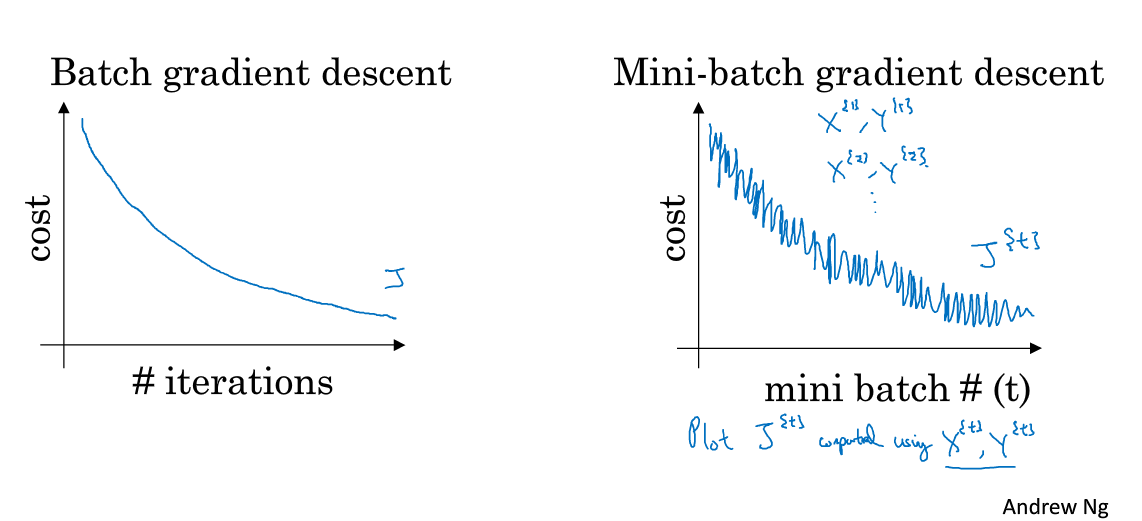

python代码:
```python
def sgd(w, dw, config=None):
    """
    Performs vanilla stochastic gradient descent.

    config format:
    - learning_rate: Scalar learning rate.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)  #{'learning_rate':1e-2}

    w -= config['learning_rate'] * dw    #随机梯度下降~
    return w, config

```

### 2. 指数加权平均 Exponentially weighted averages

统计学中又称移动加权平均.

$$v_t = \beta v_{t-1}+(1-\beta)\theta_t$$
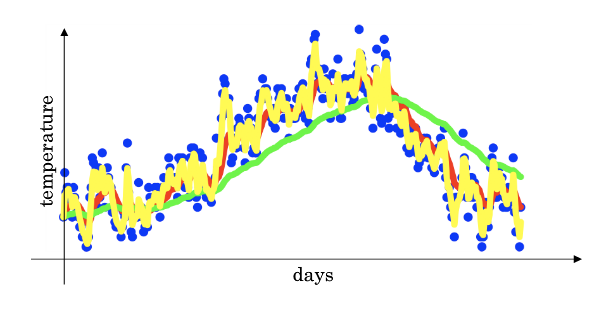
$\theta 是实际温度,v是统计规律的温度$.

$v_t = \beta v_{t-1}+(1-\beta)\theta_t$

假设$\beta =0.9$

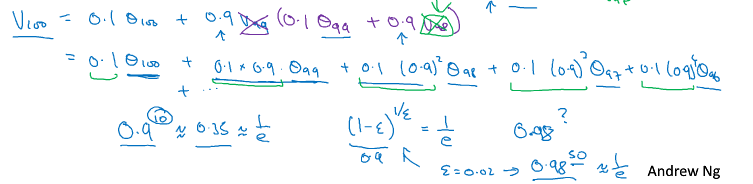

得到如图所示的指数加权平均:
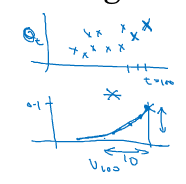

显然$\beta$越大时,之前第n填填所占的权重$(0.1\beta^n)$就越大,统计的天数n就越多. 当n=10,$\beta=0.9$时,${0.9}^{10}<\frac{1}{e}$这个时候权重太小就不考虑了.

### 3. 指数加权平均的偏差修正  bias correction

主要是针对估计的初期部分.
$v_t = \dfrac{\beta v_{t-1}+(1-\beta)\theta_t}{1-\beta}$

### 4. 动量梯度下降 Gradient descent with momentum

原理就是:纵向摆动加权平均为0,横向一直是沿着loss减小的方向,因而会加速这个方向的梯度.

$v_{dw} = \beta v_{dw}+(1-\beta)dW$

$v_{db} = \beta v_{db}+(1-\beta)db$

$W = W - \alpha v_{dw}, b = b- \alpha v_{dw}$

Hyperparameters: $\alpha, \beta$. $\beta是指数加权平均系数,\alpha是学习率$

python 代码:
```python
def sgd_momentum(w, dw, config=None):
    """
    Performs stochastic gradient descent with momentum.

    config format:
    - learning_rate: Scalar learning rate.
    - momentum: Scalar between 0 and 1 giving the momentum value.   ## 指数加权平均系数
      Setting momentum = 0 reduces to sgd.
    - velocity: A numpy array of the same shape as w and dw used to store a
      moving average of the gradients.             ## 经过加权平均后的权重,和W的shape是一样的
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)
    config.setdefault('momentum', 0.9)
    v = config.get('velocity', np.zeros_like(w)) #初始化为0
    next_w = None
    ## Nesterov Accelerated gradient
    v = config['momentum'] * v - config['learning']*dw
    next_w =  w + v
    ## Ng 讲解的似乎不太一样
    # v = config['momentum'] * v -(1 - config['momentum'])*dw
    # next_w = w - config['learning_rate'] * v
    config['velocity'] = v
    return next_w, config
```

### 5. RMSprop   root mean square prop算法

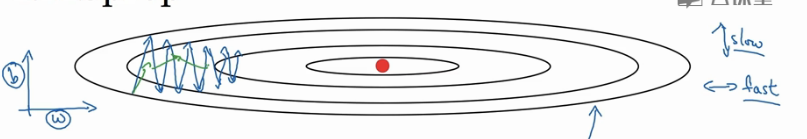


$S_{dw}=0, S_{db}=0$

$S_{dw}=\beta_2S_{dw}+(1-\beta_2)(dW)^2$

$S_{db}=\beta_2S_{db}+(1-\beta_2)(db)^2$

$W = W - \alpha \dfrac{dw}{\sqrt{S_{dw}}+\epsilon}, b = b- \alpha \dfrac{db}{\sqrt{S_{db}}+\epsilon}$

RMSprop原理: 假设纵向需要消除摆动的是参数b,当摆动很大,即$|db|$很大. 那么通过指数加权平均后,与momentum不同的是的$S_{db}^2$显然是一个比较大的数,那么$ \dfrac{db}{\sqrt{S_{db}+\epsilon}}$就相对减小,在纵向的梯度变化也会较小.

横向需要加速的是参数w,那么当dw很小的情况下,反过来的道理~~

当然在高维空间中,纵向需要消除的可能是W1,W3,W10...横向需要加速的可能是W2,W5...

```python
def rmsprop(x, dx, config=None):
    """
    Uses the RMSProp update rule, which uses a moving average of squared
    gradient values to set adaptive per-parameter learning rates.

    config format:
    - learning_rate: Scalar learning rate.
    - decay_rate: Scalar between 0 and 1 giving the decay rate for the squared
      gradient cache.
    - epsilon: Small scalar used for smoothing to avoid dividing by zero.
    - cache: Moving average of second moments of gradients.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)    ## 学习率
    config.setdefault('decay_rate', 0.99)       ## 指数加权平均衰减率
    config.setdefault('epsilon', 1e-8)
    config.setdefault('cache', np.zeros_like(x))
    next_x = None
    config['cache'] = config['decay_rate']*config['cache']+(1-config['decay_rate'])*(dx**2)
    next_x = x - config['learning_rate']*dx/(np.sqrt(config['cache'])+config['epsilon'])

    return next_x, config
```

### 6. Adam optimization algorithm

Adaptive Momentum Estimation

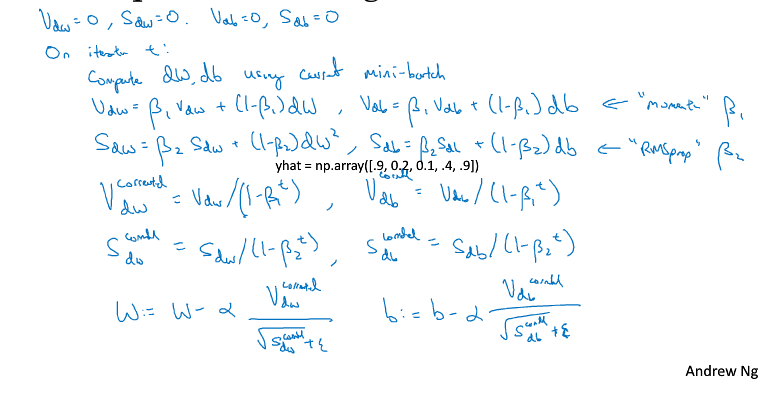

Ng的公式难得写的这么公整,我就不敲了...只是中间的yhat什么鬼...
Adam的原理也很简单:将momentum和RMSprop进行了结合,并且两个都用到了偏差修正.

超参数的设置:

$\alpha $ needs to be tune

$\beta_1:0.9$  这个dw的指数加权平均的底数

$\beta_2:0.99$   这个是$(dw^2)$的指数加权平均的底数

$\epsilon: 10^{-8}$

python 代码:
```python
def adam(x, dx, config=None):
    """
    Uses the Adam update rule, which incorporates moving averages of both the
    gradient and its square and a bias correction term.

    config format:
    - learning_rate: Scalar learning rate.
    - beta1: Decay rate for moving average of first moment of gradient.   ## dw的指数加权平均衰减率
    - beta2: Decay rate for moving average of second moment of gradient.  ## dw^2的指数加权平均衰减率
    - epsilon: Small scalar used for smoothing to avoid dividing by zero.
    - m: Moving average of gradient.   ## dw的移动平均值
    - v: Moving average of squared gradient.   ## dw^2的移动平均值
    - t: Iteration number.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-3)
    config.setdefault('beta1', 0.9)
    config.setdefault('beta2', 0.999)
    config.setdefault('epsilon', 1e-8)
    config.setdefault('m', np.zeros_like(x))
    config.setdefault('v', np.zeros_like(x))
    config.setdefault('t', 1)      ## 但是并没有传入这个参数啊..默认一直为1?
    next_x = None
    config['m'] = config['beta1']*config['m']+(1-config['beta1'])*dx
    config['v'] = config['beta2']*config['v']+(1-config['beta2'])*(dx**2)
    ##偏差修正
    m_correct = config['m']/(1-config['beta1']**config['t'])
    v_correct = config['v']/(1-config['beta2']**config['t'])
    next_x = x - config['learning_rate']*m_correct/(np.sqrt(v_correct)+config['epsilon'])
    return next_x, config
```

### 7. 学习率衰减  learning_rate decay

#### 1)指数衰减
$\alpha  = 0.95^{epoch\_num}*\alpha_0$

#### 2)
$\alpha = \dfrac{1}{1+decay\_rate*epoch\_num}*\alpha_0$

### 8. local optimal

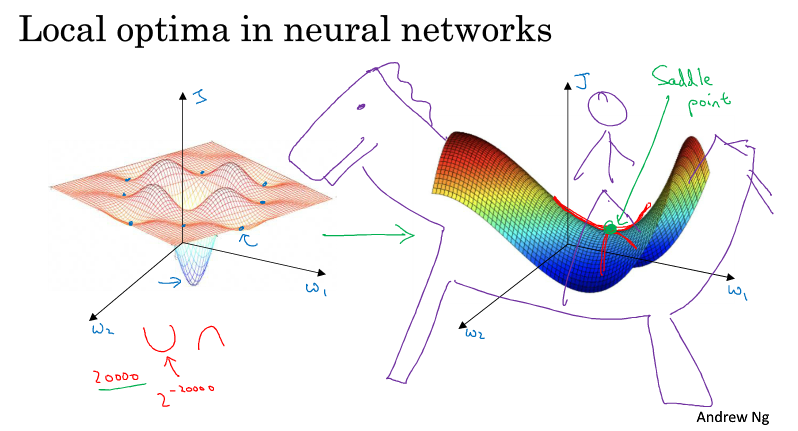
画风soooo cute!!!全世界画人儿都是一样的啊hahahhhhh 

鞍点就是梯度也为0,但却不是最优解.

In [8]:
import numpy as np
a = np.array([1,2])
a**2

array([1, 4])